<a href="https://colab.research.google.com/github/SLVmain/PyTorch_start/blob/Les_05/HW_05_GB_lips_segmentation_Unet_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Сегментация изображений</center></h1>

#Задание по итогам пятого вебинара.


Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).

И затем обучить Модель на выбор из segmentation_models_pytorch

*(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.

##  Загрузка данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -qo -O UTF-8 /content/drive/MyDrive/archive.zip -d lips/

In [5]:
!ls

drive  lips  sample_data


In [ ]:
!pip install segmentation-models-pytorch

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


import os
import time

from pathlib import Path

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim

import segmentation_models_pytorch as smp

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

In [8]:
DATASET_FILEPATH = Path('/content/lips/set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [9]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [10]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [11]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [12]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

In [13]:
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [14]:
# отбор картинок, для которых есть маска
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [15]:
IMG_SIZE = 256

In [16]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    
    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask


class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        
        # Подаем наш подготовленный датафрейм
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        
        self.data_len = len(self.data.index)


        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
      
        cls_mask_1 = mask[..., 1]

        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        
        cls_mask_1 = cls_mask_1.astype('float')

        masks = [cls_mask_1]
        
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        
        return img.float(), masks

In [20]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.2,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

BACKBONE = 'resnet34'

Umodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
Umodel.to(device)


preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [21]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
tensor(0.) tensor(1.)


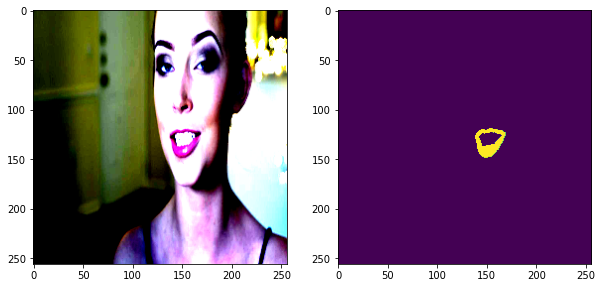

In [22]:
for imgs, masks in train_data:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs.permute(1, 2, 0))
    ax[1].imshow(masks.permute(1, 2, 0)[:,:,0])
    break

## Обучение

Для функции потерь мы будем использовать функцию Dise Loss

In [ ]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
criterion = smp.utils.losses.DiceLoss() # возьмем готовый лосс

optimizer = torch.optim.Adam(Umodel.parameters())

# запускаем главный тренировочный цикл
epoch_losses = []
Umodel.train()

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
  
        # zero the parameter gradients
        optimizer.zero_grad()
      
      
        outputs = Umodel(inputs)
        
  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
  
        # print statistics
        epoch_loss.append(loss.item())
        
        if i%50==0:
            print(f'i : {i} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    
    
    epoch_losses.append(epoch_loss)
  

i : 0 | loss : 0.046165406703948975
i : 50 | loss : 0.027977466583251953
i : 100 | loss : 0.039563536643981934
i : 150 | loss : 0.024343907833099365
i : 200 | loss : 0.030117690563201904
i : 250 | loss : 0.17734920978546143
i : 300 | loss : 0.023039817810058594
i : 350 | loss : 0.03825676441192627
i : 400 | loss : 0.031983792781829834
i : 450 | loss : 0.04303860664367676
i : 500 | loss : 0.044548094272613525
i : 550 | loss : 0.025779664516448975
i : 600 | loss : 0.058985888957977295
i : 650 | loss : 0.043842315673828125
i : 700 | loss : 0.03537172079086304
i : 750 | loss : 0.030584335327148438
i : 800 | loss : 0.060293734073638916
i : 850 | loss : 0.04057866334915161
i : 900 | loss : 0.02653324604034424
i : 950 | loss : 0.02909541130065918
i : 1000 | loss : 0.032362401485443115
i : 1050 | loss : 0.04089558124542236
i : 1100 | loss : 0.02125340700149536
i : 1150 | loss : 0.02512645721435547
i : 1200 | loss : 0.0275954008102417
i : 1250 | loss : 0.029438912868499756
i : 1300 | loss : 0.0

Сохраним нашу модель:

In [ ]:
PATH = './lipssegmodel.pth'
torch.save(Umodel, PATH)

посмотрим что вышло:

In [ ]:
data_iter1 = iter(train_loader)
images, labels = data_iter1.next()
images, labels = images.to(device), labels.to(device)

outputs = Umodel(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


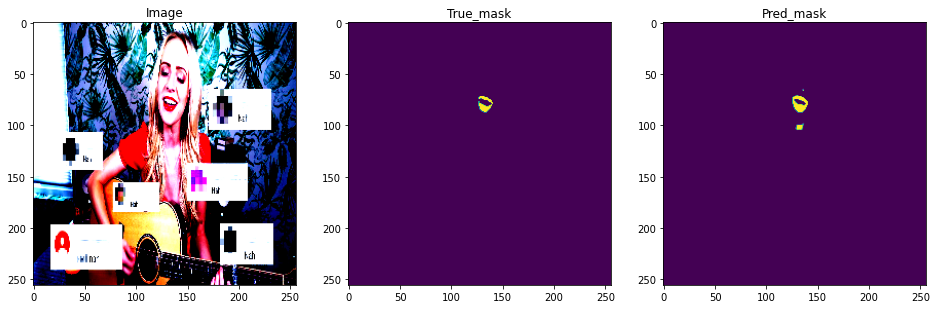

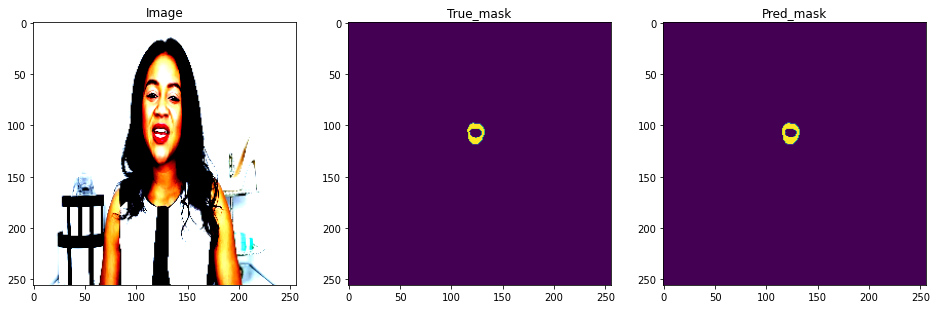

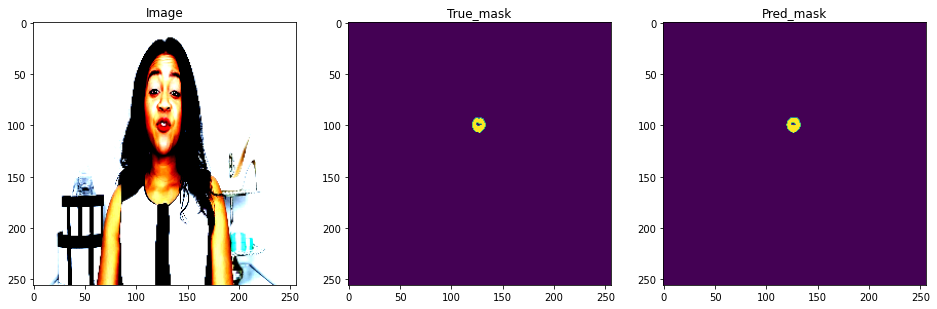

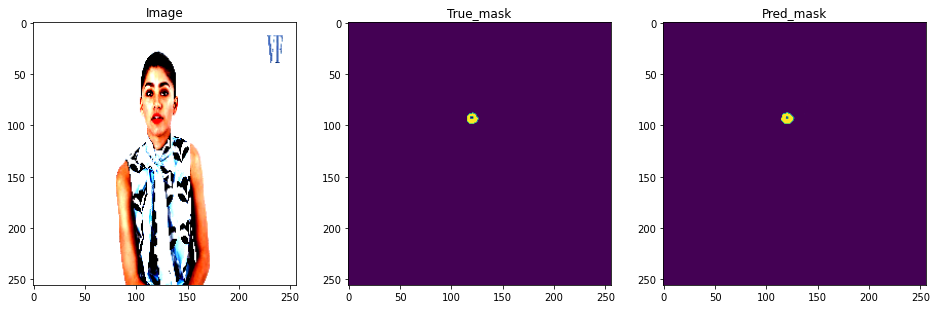

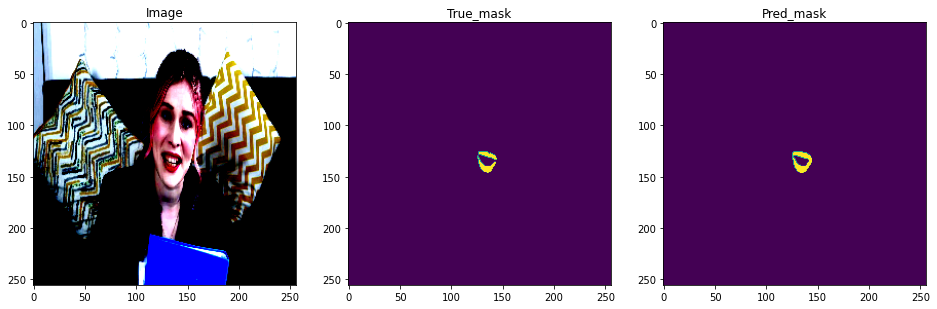

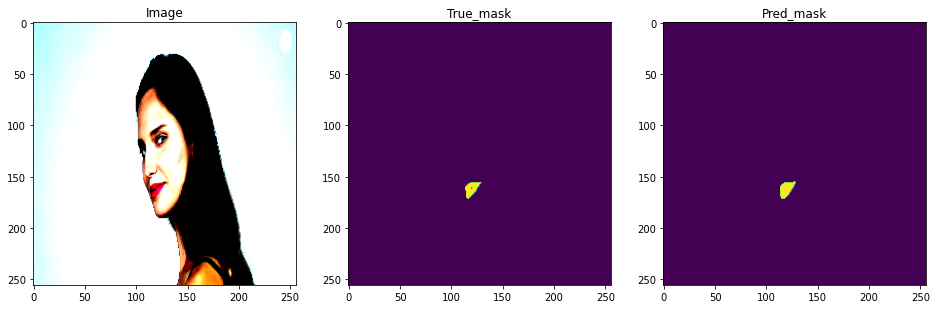

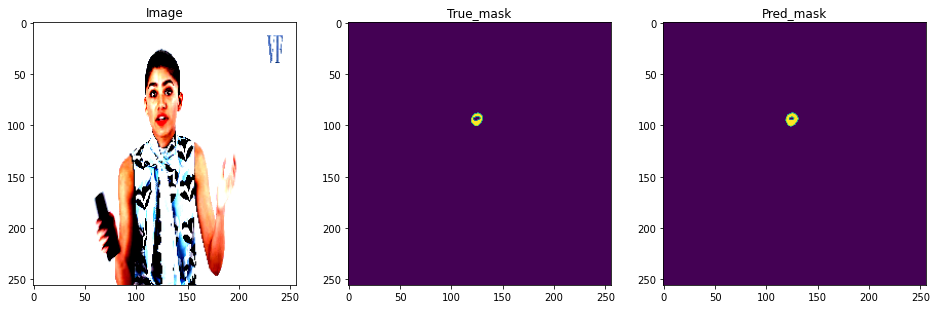

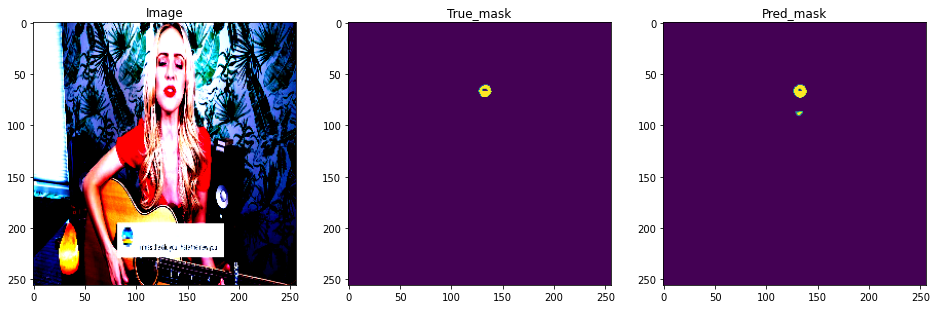

In [ ]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[:,:,0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:,:,0])
    ax_3.set_title('Pred_mask')

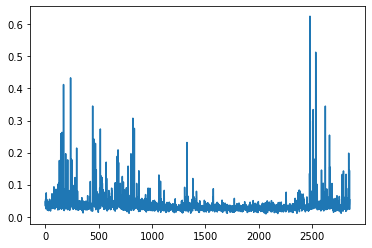

In [ ]:
plt.plot(epoch_loss)